In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
from math import pi
import warnings
warnings.filterwarnings('ignore')

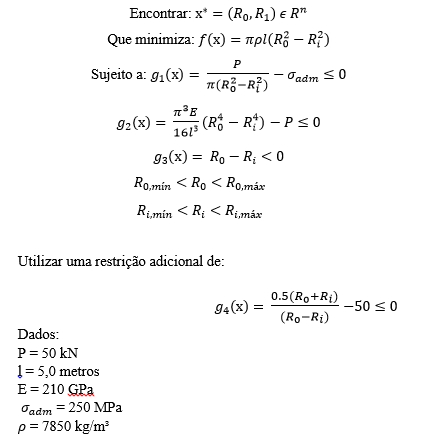

In [2]:
# Parâmetros do problema:
P = 50      # kN
l = 500     # cm
E = 2.1e4   # kN/cm²
sigma = 25  # kN/cm²
r = 7.85e-3 # kg/cm³

# Parâmetros do problema:
#P = 50000     # N
#l = 5         # m
#E = 210e9     # Pa
#sigma = 250e6 # Pa
#r = 7850      # kg/m³

# Parâmetros do algoritmo:
xi = [6.5, 6] # Ponto de partida
e1 = 1e-2     # Tolerância para o algoritmo de otimização
e2 = 1e-3     # Tolerância para o critério de parada do processo (mudança no valor da função de objetivo penalizada)
R = 1         # Parâmetro inicial de penalização
c = 1.25      # Fator de atualização de r
imax = 1e3    # Número máximo de iterações

xh = [xi] # Para armazenar o histórico de x

# Função objetivo:
def f(x):
    return (pi * r * l * (x[0]**2 - x[1]**2))

# Restrições de desigualdade:
def g(x):
    return [(P/(pi * (x[0]**2 - x[1]**2)) - sigma),
            ((pi**3 * E * (x[0]**4 - x[1]**4))/(16 * l**3) - P),
            (x[1] - x[0]),
            -((0.5 * (x[0] + x[1]))/(x[0] - x[1]) - 50)
            ]

# Restrição de igualdade:
def h(x):
    return (pi * r * l * (x[0]**2 - x[1]**2)) - 30.56 # Massa ótima (retirada do método sequencial)

# Função Ω:
def omega(x, R):
    return R * (max((g(x)[0]), 0)**2 + max((g(x)[1]), 0)**2 +
                max((g(x)[2]), 0)**2 + max((g(x)[3]), 0)**2 +
                h(x)**2)

p = lambda x: f(x) + omega(x, R) # Função de penalização

# Início do processo iterativo:
i = 0
nit = 0
nfev = 0

while True:
    i += 1
    if i > imax:
        print('Número máximo de iterações excedido!')
        break
    
    min_p = minimize(p, xh[-1], method='BFGS',
                     tol=e1, options={'maxiter':imax}) # Utiliza o método BFGS com o último x* na variável xh
    R *= c                                             # Atualiza o valor de r
    x = min_p.x                                        # O valor de x para a próxima iteração é o ótimo encontrado na atual
    nit += min_p.nit                                   # Cumulativo de iterações
    nfev += min_p.nfev                                 # Cumulativo de avaliações de funções
    
    # Critério de parada:
    if abs(p(x) - p(xh[-1])) < e2:
        xh.append([x[0], x[1]])
        print(f'Número de iterações para φ(x): {i}')
        print(f'Cumulativo de iterações para φ(x): {nit}')
        print(f'Cumulativo de avaliações de funções: {nfev}')
        print(f'Valor de f(x) no ponto ótimo: {round(f(x), 6)}')
        print(f'Valor de φ(x) no ponto ótimo: {round(p(x), 6)}')
        print(f'ε2 = {e2}')
        break
    
    xh.append([x[0], x[1]])
    
print(f'Ponto inicial: {xi}; ótimo encontrado: {xh[-1]}')

Número de iterações para φ(x): 19
Cumulativo de iterações para φ(x): 64
Cumulativo de avaliações de funções: 1593
Valor de f(x) no ponto ótimo: 30.550727
Valor de φ(x) no ponto ótimo: 30.556696
ε2 = 0.001
Ponto inicial: [6.5, 6]; ótimo encontrado: [7.948893766485234, 7.79148942282283]


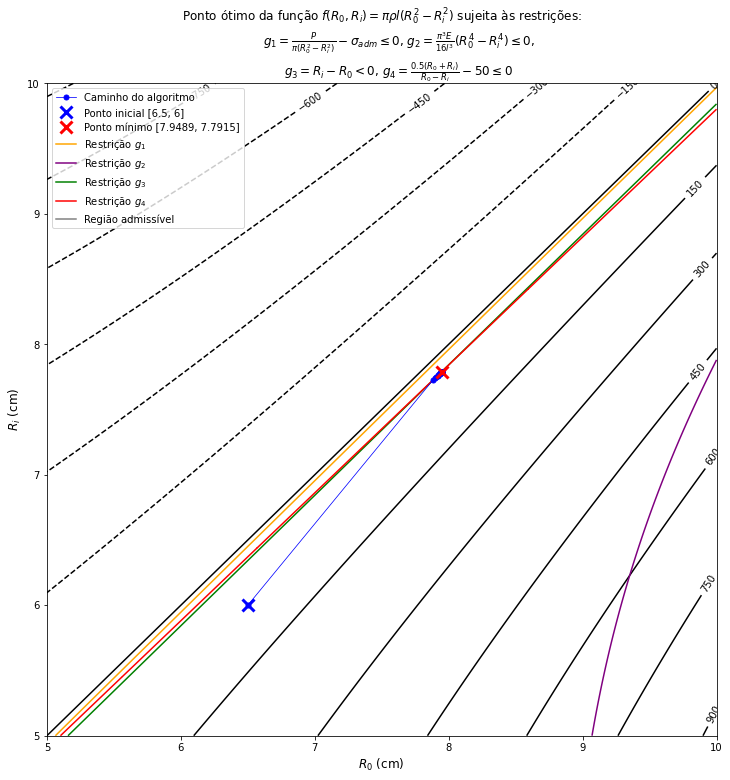

In [3]:
#### Plot:
x1h = [xh[i][0] for i in range(len(xh))]
x2h = [xh[i][1] for i in range(len(xh))]

plt.rc('figure', figsize=(12, 12))

valores = 1000
xx = np.linspace(5, 10, valores)
yy = np.linspace(5, 10, valores)
x1, x2 = np.meshgrid(xx, yy)

f = pi * r * l * (x1**2 - x2**2)
g1 = -(P/(pi * (x1**2 - x2**2)) - sigma)
g2 = -((pi**3 * E * (x1**4 - x2**4))/(16 * l**3) - P)
g3 = (x1 - x2 - 0.15743)
g4 = ((0.5 * (x1 + x2))/(x1 - x2) - 50)

fig, ax = plt.subplots()
title = (r'''Ponto ótimo da função $f(R_0, R_i) = \pi \rho l (R_0^2 - R_i^2)$ sujeita às restrições:
         $g_1 = \frac{P}{\pi (R_0^2 - R_i^2)} - \sigma_{adm} \leq 0$, $g_2 = \frac{\pi^3 E}{16 l^3}(R_0^4 - R_i^4) \leq 0$,
         $g_3 = R_i - R_0 < 0$, $g_4 = \frac{0.5(R_0 + R_i)}{R_0 - R_i} - 50 \leq 0$''')
CS = ax.contour(xx, yy, f, 15, colors='k')
ax.clabel(CS, inline=0.5, fontsize=10)
ax.set_title(title)

string = f'Ponto mínimo [{round(xh[-1][0], 4)}, {round(xh[-1][1], 4)}]'
    
plt.plot(x1h, x2h, marker='.', lw=0.75, ms=10, label='Caminho do algoritmo', c='blue')
plt.plot(xi[0], xi[1], marker='x', ls='', ms=12, label=f'Ponto inicial {xi}', c='blue', mew=3)
plt.plot(xh[-1][0], xh[-1][1], marker='x', ls='', ms=12, label=string, c='r', mew=3)
plt.plot(xx[0], yy[0], label=r'Restrição $g_1$', c='orange')
plt.plot(xx[0], yy[0], label=r'Restrição $g_2$', c='purple')
plt.plot(xx[0], yy[0], label=r'Restrição $g_3$', c='g')
plt.plot(xx[0], yy[0], label=r'Restrição $g_4$', c='r')
plt.plot(xx[0], yy[0], label='Região admissível', c='gray')
plt.contour(xx, yy, g1, 0, colors='orange')
plt.contour(xx, yy, g2, 0, colors='purple')
plt.contour(xx, yy, g3, 0, colors='g')
plt.contour(xx, yy, g4, 0, colors='r')
plt.xlabel(r'$R_0$ (cm)', fontsize=12)#, fontweight='bold')
plt.ylabel(r'$R_i$ (cm)', fontsize=12)#, fontweight='bold')

plt.legend(loc='upper left')
plt.xlim((5, 10))
plt.ylim((5, 10))

plt.show()